In [98]:
#import argparse
import os
import numpy as np
import pandas as pd
import deepchem as dc
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV
from deepchem.utils.data_utils import load_from_disk, save_to_disk
import umap
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from pycaret.datasets import get_data
from pycaret.classification import *

In [68]:
TRAIN = "../data/smiles_all_property.csv"
TARGET_COL = "HOMO/LUMO gap"
SMILES_COL = "smiles"
PROPERTY = TARGET_COL


if TARGET_COL == "Decomposition Energy":
    PROPERTY = "Decomposition_Energy"
elif TARGET_COL == "HOMO/LUMO gap":
    PROPERTY = "HOMOLUMO_gap"

MODEL_DIR = "../model/" + PROPERTY
LOG_DIR = "../log/" + PROPERTY

DATA_DIR = "../data/" + PROPERTY

DATA_EXIST = os.path.exists(DATA_DIR + "/tasks.json")

In [69]:

def model_builder(**model_params):
    estimator = LGBMRegressor()
    estimator.set_params(**model_params)
    return dc.models.SklearnModel(estimator)

In [70]:
featurizer = dc.feat.RDKitDescriptors()

In [71]:
# 学習データの読み込み
loader = dc.data.CSVLoader(tasks=[TARGET_COL],
                            feature_field=SMILES_COL,
                            featurizer=featurizer)

In [72]:
if DATA_EXIST == True:
        dataset = dc.data.DiskDataset(DATA_DIR)
else:
        dataset = loader.create_dataset(TRAIN, data_dir=DATA_DIR)

print("Data loaded.")

Data loaded.


In [73]:
splitter = dc.splits.IndexSplitter()

In [74]:
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset, frac_train=0.6, frac_valid=0.2, frac_test=0.2)

In [75]:
transformers = [dc.trans.NormalizationTransformer(transform_y=True,dataset=train_dataset)]

In [76]:
for transformer in transformers:
    train_dataset = transformer.transform(train_dataset)
    valid_dataset = transformer.transform(valid_dataset)
    #test_dataset = transformer.transform(test_dataset)

In [77]:
print(train_dataset.X.shape)
print(valid_dataset.X.shape)
print(test_dataset.X.shape)

(52576, 208)
(17526, 208)
(17526, 208)


In [78]:
train_dataset.X

array([[ 8.65305556,  0.08796296,  8.65305556, ...,  0.        ,
         0.        ,  0.        ],
       [ 8.69802469,  0.24481481,  8.69802469, ...,  0.        ,
         0.        ,  0.        ],
       [10.19856481, -0.67361111, 10.19856481, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 4.9600463 ,  0.53303655,  4.9600463 , ...,  0.        ,
         0.        ,  0.        ],
       [12.91320122, -0.21767248, 12.91320122, ...,  0.        ,
         0.        ,  0.        ],
       [13.09113958, -3.95995607, 13.09113958, ...,  0.        ,
         0.        ,  0.        ]])

In [79]:
print(dataset)
print(train_dataset)

<DiskDataset X.shape: (87628, 208), y.shape: (87628, 1), w.shape: (87628, 1), task_names: ['HOMO/LUMO gap']>
<DiskDataset X.shape: (52576, 208), y.shape: (52576, 1), w.shape: (52576, 1), task_names: ['HOMO/LUMO gap']>


In [80]:
df_concat = pd.concat([pd.DataFrame(dataset.X), pd.DataFrame(dataset.y, columns=['target'])], axis=1)
df_concat

,0,1,2,3,4,5,6,7,8,9,...,199,200,201,202,203,204,205,206,207,target
0,8.653056,0.087963,8.653056,0.087963,0.524584,110.112,104.064,110.036779,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.016080
1,8.698025,0.244815,8.698025,0.244815,0.567108,128.558,123.518,128.002892,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.688187
2,10.198565,-0.673611,10.198565,0.173611,0.276433,111.100,106.060,111.032028,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.769276
3,4.016204,0.968148,4.016204,0.968148,0.496894,108.144,100.080,108.068748,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.420703
4,4.016204,1.006944,4.016204,1.006944,0.496894,108.144,100.080,108.068748,42.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.434581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87623,12.440187,-0.597407,12.440187,0.396543,0.783851,349.814,329.654,349.108086,128.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.457706
87624,13.053721,-0.371447,13.053721,0.021000,0.817362,322.380,299.196,322.169271,126.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.574445
87625,12.562618,-3.460636,12.562618,0.070410,0.907062,329.465,306.281,329.144950,122.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.833494
87626,12.480677,-3.689559,12.480677,0.113969,0.875365,335.425,314.257,335.119129,124.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.152675


In [81]:
import multiprocessing
multiprocessing.cpu_count()

8

In [82]:
# PyCaretを起動
from pycaret.regression import *
exp1 = setup(data = df_concat, target='target')

,Description,Value
0,Session id,658
1,Target,target
2,Target type,Regression
3,Original data shape,"(87628, 209)"
4,Transformed data shape,"(87628, 209)"
5,Transformed train set shape,"(61339, 209)"
6,Transformed test set shape,"(26289, 209)"
7,Numeric features,208
8,Preprocess,True
9,Imputation type,simple


In [83]:
# 45mほどかかる
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.1974,0.0782,0.2796,0.8672,0.0517,0.0444,56.8840
rf,Random Forest Regressor,0.2162,0.0906,0.3010,0.8460,0.0554,0.0485,111.0330
lightgbm,Light Gradient Boosting Machine,0.2459,0.1036,0.3219,0.8239,0.0592,0.0551,1.6200
gbr,Gradient Boosting Regressor,0.3026,0.1518,0.3896,0.7421,0.0713,0.0678,44.0530
ridge,Ridge Regression,0.3014,0.1520,0.3898,0.7419,0.0715,0.0674,0.6170
br,Bayesian Ridge,0.3014,0.1519,0.3898,0.7419,0.0715,0.0674,1.2800
lr,Linear Regression,0.3013,0.1520,0.3898,0.7418,0.0716,0.0674,0.8930
dt,Decision Tree Regressor,0.2941,0.1879,0.4334,0.6808,0.0797,0.0656,2.5980
knn,K Neighbors Regressor,0.3406,0.2087,0.4569,0.6453,0.0830,0.0765,3.0770
ada,AdaBoost Regressor,0.4217,0.2699,0.5195,0.5413,0.0929,0.0914,19.4650


In [84]:
best_model

ExtraTreesRegressor(n_jobs=-1, random_state=658)

In [85]:
plot_model(best_model, plot = 'parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
criterion,squared_error
max_depth,None
max_features,1.0
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1
min_samples_split,2


In [86]:
pred_holdout = predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1952,0.0764,0.2764,0.8679,0.0511,0.0439


In [90]:
pred_holdout

,0,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,target,prediction_label
52359,12.303818,-0.417222,12.303818,0.218384,0.635424,307.371002,290.234985,307.087830,112.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.907504,4.580833
46762,11.723121,-0.372425,11.723121,0.372425,0.482137,345.807007,333.710999,345.022644,116.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.361375,3.769035
25463,11.273765,-0.942703,11.273765,0.130998,0.900914,280.369995,268.273987,280.022797,94.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.566550,4.749269
31973,11.272863,-0.465171,11.272863,0.067578,0.635876,233.251999,226.195999,233.025894,80.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.420427,4.064560
19987,12.397575,-3.639722,12.397575,0.056330,0.884928,278.329010,264.217010,278.061279,100.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.278390,4.915618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44883,11.799129,-0.403513,11.799129,0.054555,0.456986,341.367004,322.214996,341.137543,130.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.028040,4.031768
17438,12.304719,-3.662387,12.304719,0.151099,0.883189,310.806000,295.686005,310.054291,106.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.264784,5.181879
5860,11.408503,0.082141,11.408503,0.082141,0.789193,192.261993,176.134003,192.126266,76.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.696895,5.983971
8084,11.517860,-0.535204,11.517860,0.009951,0.374036,312.281006,300.184998,312.074615,116.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.214163,3.358916


In [111]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=pred_holdout['prediction_label'], y=pred_holdout['target'], mode='markers', marker=dict(
        size=2,
    )))
fig.add_trace(go.Scatter(x=np.array(range(0, 11)), y=np.array(range(0, 11)),
                    mode='lines'))
fig.update_layout(width=700, height=700)
fig.update_yaxes(scaleanchor='x')

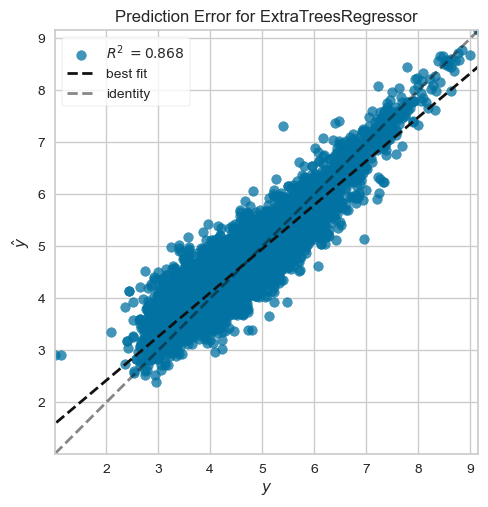

In [87]:
plot_model(best_model, plot = 'error')

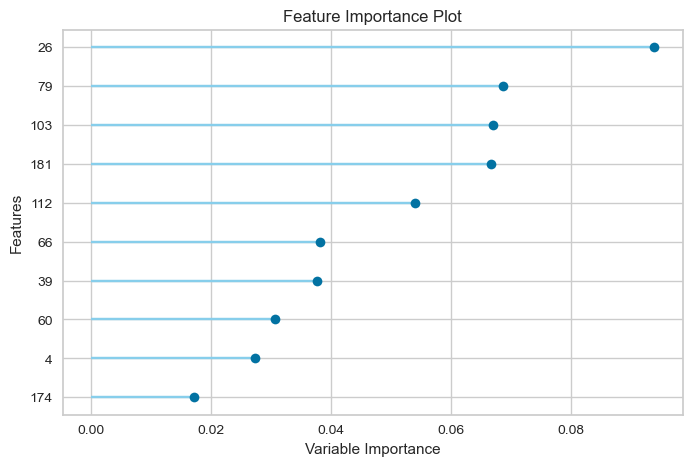

In [88]:
plot_model(best_model, plot = 'feature')

In [89]:
# train model
et = create_model('et')

evaluate_model(et)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…